# Cross Validation and Grid Search

Here are examples of cross validation (running the same model with different training sets to get statistics on the performance) and grid search (trying an exhaustive search in parameter space.)

In [1]:
from sklearn.datasets import fetch_openml

In [128]:
# Try this -- it may get blocked by LCPS?

# uncomment next line
# mnist = fetch_openml('mnist_784', as_frame=False)

In [141]:
# if above doesn't work, do this.
# first download and gunzip the file from github "mnist.gzip"

infile = open("mnist.pk", "rb")
mnist = pickle.load(infile)

In [142]:
X,y = mnist.data, mnist.target
X.shape, y.shape

((70000, 784), (70000,))

In [143]:
from sklearn.model_selection import train_test_split

Note we use a subset of the data!

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.01, train_size=0.1)

In [145]:
X_train.shape, X_test.shape

((7000, 784), (700, 784))

Let's make a binary classifier first : "5" or "not 5"

In [146]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

SGD (standard gradient descent) is a type of linear classifier that minimizes a loss function. We use it here just because it's different.

In [149]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

In [150]:
sgd_classifier = SGDClassifier(random_state = 42)
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [151]:
y_pred = sgd_classifier.predict(X_test)

In [152]:
accuracy_score(y_pred, y_test_5)

0.9242857142857143

Now we try cross validation -- it runs the same model training with 5 different subsets of the training set. It validates it on the remainder. This is called k-fold validation. (you can change the 5)

In [154]:
from sklearn.model_selection import cross_val_score

In [155]:
cross_val_score(sgd_classifier, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.93642857, 0.95285714, 0.965     , 0.94285714, 0.95428571])

As an example we do a KNN also

In [161]:
from sklearn.neighbors import KNeighborsClassifier

In [162]:
knn_classifier = KNeighborsClassifier(n_neighbors=7)
knn_classifier.fit(X_train, y_train_5)

KNeighborsClassifier(n_neighbors=7)

In [163]:
cross_val_score(knn_classifier, X_train, y_train_5, cv=5, scoring="accuracy")

array([0.98142857, 0.98285714, 0.98642857, 0.97928571, 0.98785714])

KNN can do multiclass, so let's throw the 10-class original training set at it.

In [165]:
cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring="accuracy")

array([0.92142857, 0.92928571, 0.93214286, 0.935     , 0.94      ])

Let's look at some statistics. We'll run it 20 times and use a pandas dataset as a quick way to get stats.

In [166]:
knn_results = cross_val_score(knn_classifier, X_train, y_train, cv=20, scoring="accuracy")

In [167]:
import pandas as pd

In [168]:
pd.Series(knn_results).describe()

count    20.000000
mean      0.935286
std       0.015712
min       0.897143
25%       0.925000
50%       0.938571
75%       0.946429
max       0.957143
dtype: float64

## Grid Search

A grid search takes a list of parameters and does a cross-validation on each parameter. It is a slow, exhaustive way to find the best setting for your model.

In [171]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Create pipeline
pipeline = make_pipeline(KNeighborsClassifier())

# Define parameter grid
param_grid = {
    'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')

# Print the grid_search to confirm no errors
print(grid_search)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5,
                                                               10, 15, 20, 25,
                                                               30]},
             scoring='accuracy')


In [172]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 2, 3, 4, 5,
                                                               10, 15, 20, 25,
                                                               30]},
             scoring='accuracy')

We'll do lots of analysis on these results. The final best model is below.

In [176]:
knn_cv_results = pd.DataFrame(grid_search.cv_results_)

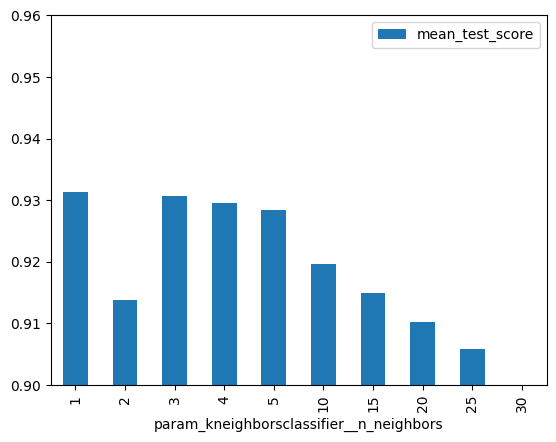

In [177]:
knn_cv_results.plot(x='param_kneighborsclassifier__n_neighbors', y='mean_test_score',
                   kind='bar',ylim=(0.9,0.96));

In [178]:
knn_cv_results.sort_values(by="mean_test_score", ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kneighborsclassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007946,0.000249,0.310262,0.025345,1,{'kneighborsclassifier__n_neighbors': 1},0.929306,0.929276,0.935276,0.931286,0.002822,1
2,0.007560,0.000114,0.302895,0.001498,3,{'kneighborsclassifier__n_neighbors': 3},0.928021,0.931847,0.932276,0.930715,0.001913,2
3,0.007949,0.000220,0.304707,0.000642,4,{'kneighborsclassifier__n_neighbors': 4},0.922451,0.936562,0.929704,0.929572,0.005762,3
4,0.007629,0.000078,0.357236,0.038274,5,{'kneighborsclassifier__n_neighbors': 5},0.919023,0.931847,0.934419,0.928430,0.006734,4
5,0.007763,0.000119,0.316748,0.001378,10,{'kneighborsclassifier__n_neighbors': 10},0.911740,0.919417,0.927990,0.919715,0.006637,5
6,0.007739,0.000099,0.318783,0.001494,15,{'kneighborsclassifier__n_neighbors': 15},0.909597,0.913845,0.921132,0.914858,0.004763,6
1,0.007761,0.000141,0.305129,0.005059,2,{'kneighborsclassifier__n_neighbors': 2},0.906598,0.917274,0.917703,0.913858,0.005137,7
7,0.007741,0.000081,0.321838,0.003609,20,{'kneighborsclassifier__n_neighbors': 20},0.904456,0.909130,0.917274,0.910287,0.005296,8
8,0.007664,0.000111,0.320703,0.001444,25,{'kneighborsclassifier__n_neighbors': 25},0.903599,0.900557,0.913416,0.905857,0.005487,9
9,0.007810,0.000041,0.341753,0.017311,30,{'kneighborsclassifier__n_neighbors': 30},0.896315,0.891985,0.911702,0.900001,0.008461,10


In [179]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'kneighborsclassifier__n_neighbors': 1}


In [180]:
best_model = grid_search.best_estimator_
print("Best Model:", best_model)

Best Model: Pipeline(steps=[('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])


In [181]:
# Evaluate the best model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy with Best Model:", accuracy)

Test accuracy with Best Model: 0.9442857142857143
